In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Union, Tuple, List

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

# local modules
import sys
sys.path.append("../src")
from preproc import preprocess_data

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Call the function
df_train, df_test, numerical_cols, categorical_cols = preprocess_data(
    df_train,
    df_test,
    scale_utility=True
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

Numerical Columns: 588
Categorical Columns: 10


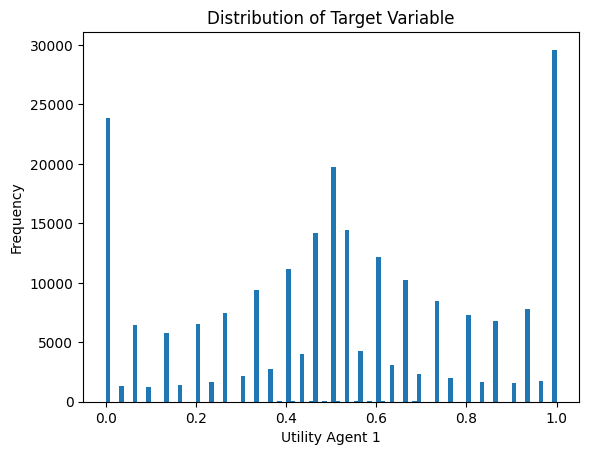

In [4]:
plt.hist(df_train['utility_agent1_scaled'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [5]:
df_train[numerical_cols] = df_train[numerical_cols].astype(np.float32)
df_train[categorical_cols] = df_train[categorical_cols].astype(np.int32)

cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[72, 72, 4, 3, 3, 2, 4, 3, 3, 2]


In [6]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns of df_train
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])

# Print a message to confirm the scaling
print("Numerical columns have been scaled using StandardScaler.")


Numerical columns have been scaled using StandardScaler.


***
### train model


In [7]:
class MLP(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            layers: str,
            dropout: float,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            initialization: str = 'kaiming_uniform',
            embedding_dim: Optional[List[int]] = None,
        ):
        super().__init__()
        self.save_hyperparameters()

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            # Rule of thumb: min(50, num_unique // 2 + 1) for each categorical feature
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]

        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")

        self.embedding_dim = embedding_dim

        # Create embedding layers
        self.create_embeddings(cat_input_dims, embedding_dim)

        # Create backbone layers
        self.create_backbone(num_input_dim, layers)

        # Create head layers
        self.create_head(output_dim)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.initialization = initialization

        self._init_weights()

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def create_embeddings(self, cat_input_dims: list[int], embedding_dim: list[int]):
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )

    def create_backbone(self, num_input_dim: int, layers: str):
        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # Parse layers string
        layer_sizes = [int(size) for size in layers.split('-')]

        # Create backbone network layers
        backbone_layers = []
        prev_size = total_input_dim
        for size in layer_sizes:
            backbone_layers.extend([
                nn.BatchNorm1d(prev_size),
                nn.Linear(prev_size, size),
                nn.ReLU(),
                nn.Dropout(self.hparams.dropout),
            ])
            prev_size = size
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_output_size = prev_size

    def create_head(self, output_dim: int):
        # Output layer
        self.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone_output_size),
            nn.Linear(self.backbone_output_size, output_dim)
        )

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if any(module is m for m in self.head.modules()):
                    nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('tanh'))
                else:
                    if self.initialization == 'kaiming_uniform':
                        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'kaiming_normal':
                        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                    elif self.initialization == 'xavier_uniform':
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                    elif self.initialization == 'xavier_normal':
                        nn.init.xavier_normal_(module.weight, gain=nn.init.calculate_gain('relu'))
                    else:
                        raise ValueError(f"Unsupported initialization method: {self.initialization}")
                
                # Initialize bias to small values
                if module.bias is not None:
                    nn.init.uniform_(module.bias, -0.1, 0.1)

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)
        
        # Pass through backbone
        x = self.backbone(x)
        
        # Pass through head
        x = self.head(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.2,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [8]:
early_stop_callback = EarlyStopping(
    monitor='val_rmse',
    patience=10,
    mode='min',
    verbose=False
)

class LearningRateMonitor(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % 100 == 0:  # Log every 100 batches
            lr = pl_module.optimizers().param_groups[0]['lr']
            pl_module.log('learning_rate', lr, prog_bar=True)   

class BestValRMSELogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_rmse = float('inf')

    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_rmse = trainer.callback_metrics.get('val_rmse')
        if current_val_rmse is not None:
            self.best_val_rmse = min(self.best_val_rmse, current_val_rmse)
            pl_module.log('best_val_rmse', self.best_val_rmse, prog_bar=True)


In [9]:
params = {
    'batch_size': 192,
    'dropout': 0.2,
    'input_layer_size': 896,
    'n_layers': 3,
    'learning_rate': 0.000809012039564196,
    'weight_decay': 0.0006460125913056128,
    'initialization': 'kaiming_uniform',
    'pct_start': 0.05
}

In [10]:
# Define the number of folds for cross-validation
num_folds = 5

# Define the column for stratified or group k-fold
groups_col = 'GameRulesetName'
gkf = GroupKFold(n_splits=num_folds)
split_list = gkf.split(df_train, groups=df_train[groups_col])

trained_models = []
oof = pd.DataFrame(index=df_train.index, columns=['utility_agent1_true', 'utility_agent1_pred'])
oof_scores = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(split_list, 1):
    print(f"Fold {fold}")
    
    # Split the data
    train, valid = df_train.iloc[train_index], df_train.iloc[val_index]

    train_dataset = TensorDataset(
        torch.tensor(train[numerical_cols].values, dtype=torch.float32),
        torch.tensor(train[categorical_cols].values, dtype=torch.int32),
        torch.tensor(train['utility_agent1'].values, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=8,
        persistent_workers=True
    )

    valid_dataset = TensorDataset(
        torch.tensor(valid[numerical_cols].values, dtype=torch.float32),
        torch.tensor(valid[categorical_cols].values, dtype=torch.int32),
        torch.tensor(valid['utility_agent1'].values, dtype=torch.float32)
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=8,
        persistent_workers=True
    )

    # Construct the layers string based on input_layer_size and n_layers
    input_layer_size = params['input_layer_size']
    n_layers = params['n_layers']
    layers = "-".join([str(input_layer_size // (2 ** i)) for i in range(n_layers)])

    model = MLP(
        num_input_dim=len(numerical_cols),
        cat_input_dims=cat_input_dims,
        output_dim=1,
        layers=layers,
        dropout=params['dropout'],
        learning_rate=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        initialization=params['initialization'],
    )
    trainer = pl.Trainer(
        min_epochs=20, 
        max_epochs=100, 
        #deterministic=True,
        accelerator="mps", 
        #devices=1,
        callbacks=[
            early_stop_callback, 
            LearningRateMonitor(), 
            BestValRMSELogger(),
            ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
        ],
    )
    trainer.fit(
        model, 
        train_loader,
        valid_loader,
    )

    # Load the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    model = MLP.load_from_checkpoint(best_model_path)

    # Predict on validation set using trainer.predict with the prediction DataLoader
    predictions = trainer.predict(model, dataloaders=valid_loader)
    y_pred = torch.cat(predictions).squeeze().cpu().numpy()
     
    # Compute RMSE on scaled values
    y_valid = valid['utility_agent1'].values
    rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
    print(f"Fold {fold} - RMSE: {rmse}")

    # Save out-of-fold predictions
    oof.loc[val_index, 'utility_agent1_true'] = y_valid
    oof.loc[val_index, 'utility_agent1_pred'] = y_pred

    # Save RMSE to the list
    oof_scores.append(rmse)

# Print the list of oof scores and average oof score
print("List of oof scores:", oof_scores)
print("Average oof score:", np.mean(oof_scores))

oof.to_csv(path_results / 'oof_mlp.csv', index=False)


Fold 1


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | ModuleList | 1.5 K  | train
1 | backbone   | Sequential | 1.1 M  | train
2 | head       | Sequential | 673    | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 1 - RMSE: 0.4608323261390209
Fold 2


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | ModuleList | 1.5 K  | train
1 | backbone   | Sequential | 1.1 M  | train
2 | head       | Sequential | 673    | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 2 - RMSE: 0.49073315065460704
Fold 3


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | ModuleList | 1.5 K  | train
1 | backbone   | Sequential | 1.1 M  | train
2 | head       | Sequential | 673    | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 3 - RMSE: 0.4972671099936193
Fold 4


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | ModuleList | 1.5 K  | train
1 | backbone   | Sequential | 1.1 M  | train
2 | head       | Sequential | 673    | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 4 - RMSE: 0.462809748523913
Fold 5


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | embeddings | ModuleList | 1.5 K  | train
1 | backbone   | Sequential | 1.1 M  | train
2 | head       | Sequential | 673    | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.303     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Fold 5 - RMSE: 0.46839836892944103
List of oof scores: [0.4608323261390209, 0.49073315065460704, 0.4972671099936193, 0.462809748523913, 0.46839836892944103]
Average oof score: 0.4760081408481202


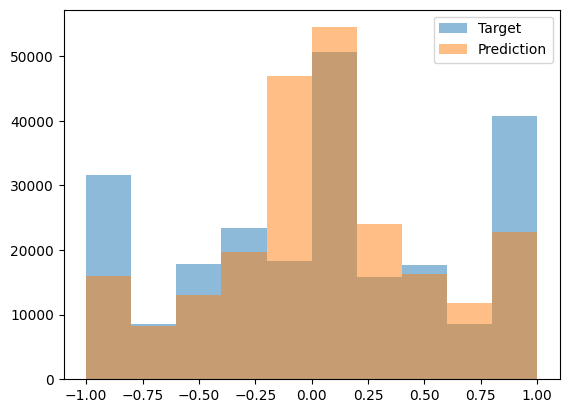

In [11]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***